In [549]:
#Awesome Oscillator is using the 5 and 34 EMA's, and the differce between them. 
#Signal is when we get two red bars in a row, and then a green bar above zero level for a long and vice versa. 

import pandas as pd
import numpy as np 
npNaN = np.nan
import pandas_ta as ta
import matplotlib.pyplot as plt
import config
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.orders as orders
from datetime import datetime, timezone
import time 


In [550]:
#Setting up Oanda Connection 
client = API(access_token=config.OANDA_API_KEY, environment=config.ENVIRONMENT)
client

In [551]:
#defining variables
timeframe = "H2" 
instrument = "SPX500_USD"

In [552]:
#Bot will regularly need to get the latest data, so we will define a function to do that
def get_candles(tf):    
    params = {
        "granularity": tf,
        "price": "A" #ask prices 
    }
    #Getting historical data
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    #sending API request to Oanda 
    candles = client.request(r)['candles']
    #Organising the data into a DataFrame
    data = []

    for c in candles:
        if c["complete"]:
            data.append({
                "time": c["time"],
                "open": float(c["ask"]["o"]),
                "high": float(c["ask"]["h"]),
                "low": float(c["ask"]["l"]),
                "close": float(c["ask"]["c"]),
                "volume": int(c["volume"])
        })
    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"])
    #Dont forget to added the retun now its in a function 
    return df


In [553]:
#Acccessing the data
price = get_candles(timeframe)
price


,time,open,high,low,close,volume
0,2025-06-24 23:00:00+00:00,6097.4,6104.9,6095.1,6103.9,1608
1,2025-06-25 01:00:00+00:00,6103.9,6103.9,6096.9,6098.6,988
2,2025-06-25 03:00:00+00:00,6098.9,6104.1,6098.9,6104.1,444
3,2025-06-25 05:00:00+00:00,6103.9,6106.1,6102.1,6102.1,931
4,2025-06-25 07:00:00+00:00,6101.9,6105.4,6097.9,6104.4,2811
...,...,...,...,...,...,...
495,2025-08-21 11:00:00+00:00,6387.9,6393.4,6370.1,6372.1,6090
496,2025-08-21 13:00:00+00:00,6372.1,6397.6,6360.8,6389.3,16267
497,2025-08-21 15:00:00+00:00,6389.6,6394.1,6364.8,6366.8,8794
498,2025-08-21 17:00:00+00:00,6366.8,6380.8,6356.3,6379.3,5672


In [554]:
#Lets plots the chart 
#plt.plot(df['close'])
#plt.show()

In [555]:

#Calculating Awesome Oscllator 

price['AO'] = ta.ao(price['high'], price['low'])
#is the histogram green or red, just need to check if its green as its either one or the other
price['AO_Green'] = price['AO'] > price['AO'].shift(1)
#Just want to see the last 10 rows of the data
price.tail(10)

# 'saucer' Signal is when we get two red bars in a row, and then a green bar below zero level for a long and vice versa.
#looks at current row and previous two rows to see if they are all above zero
price['Above_Zero'] = (price['AO'] > 0) & (price['AO'].shift(1) > 0) & (price['AO'].shift(2) > 0)
price['Saucer'] = (price['AO_Green'] == True) & (price['AO_Green'].shift(1) == False) & (price['AO_Green'].shift(2) == False)

price['Signal'] = (price['Above_Zero'] == True) & (price['Saucer'] == True)
#Filter for only rows that have signal in them 
#price[price['Signal']]
#Using the above line of code we can see that the first signal is on 07/25 1pm
#we want to accese it acouple of candles before hand though 
price.loc[price['time'] >= "2025-07-24 22:00:00+00:00"]
                        


,time,open,high,low,close,volume,AO,AO_Green,Above_Zero,Saucer,Signal
261,2025-07-24 23:00:00+00:00,6380.5,6385.0,6377.7,6384.0,878,33.763824,False,True,False,False
262,2025-07-25 01:00:00+00:00,6384.5,6389.0,6383.7,6387.0,619,33.318235,False,True,False,False
263,2025-07-25 03:00:00+00:00,6386.7,6391.5,6381.0,6382.0,582,32.051176,False,True,False,False
264,2025-07-25 05:00:00+00:00,6382.0,6384.7,6378.7,6379.2,806,30.694118,False,True,False,False
265,2025-07-25 07:00:00+00:00,6379.5,6380.2,6371.7,6376.7,2891,28.090588,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
495,2025-08-21 11:00:00+00:00,6387.9,6393.4,6370.1,6372.1,6090,-22.962941,False,False,False,False
496,2025-08-21 13:00:00+00:00,6372.1,6397.6,6360.8,6389.3,16267,-25.072353,False,False,False,False
497,2025-08-21 15:00:00+00:00,6389.6,6394.1,6364.8,6366.8,8794,-26.596471,False,False,False,False
498,2025-08-21 17:00:00+00:00,6366.8,6380.8,6356.3,6379.3,5672,-29.353235,False,False,False,False


In [556]:
#Now we want to se eif these signals are better than just taking random entries 
#so were going to calcialte the reuturn after a certain number of days to see if taking the trade signal is better over what tiemframe 
days = [1, 2, 3, 4, 5, 10, 25, 50, 100]
#iterate through days list and calcaulte a return
#close price shifted by the number that is i, i.e the numebr of days, or rows lower 
#df['Open'].shift(-1) is becasue the trade will open at the start of the next candle
#-1 to calculate a return 
for i in days:
    price[f'Ret_{i}'] = (price['close'].shift(-i) / price['open'].shift(-1)) - 1
#usingthe below code will output the reuturn for every row, now just the ones with a signal 
#price


In [557]:
#identifys the reuturn colums to make the next line eaisier 
ret_columns = [f'Ret_{day}' for day in days]
#ret_colums
sys_results = price[price['Signal']][ret_columns]
#sys_results
#remaining rows calcualtion
remaining_rows = price[~price['Signal']][ret_columns]

sys_profits = sys_results[sys_results > 0].sum()
sys_losses = abs(sys_results[sys_results < 0].sum())

bench_mark_profits = remaining_rows[remaining_rows > 0].sum()
bench_mark_losses = abs(remaining_rows[remaining_rows < 0].sum())
sys_pf = sys_profits / sys_losses
bench_mark_pf = bench_mark_profits / bench_mark_losses
#shows the profit factor for each of the time frames
#sys_pf




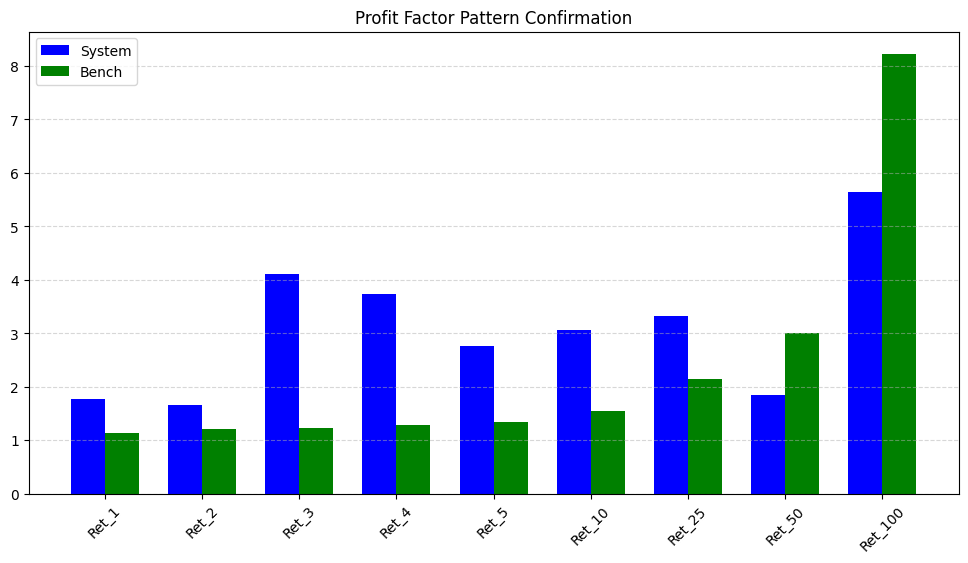

In [558]:
#Plotting the profit factor 
#Create the figure 
plt.figure(figsize=(12, 6))
bar_width = 0.35
#define a few variables
x_pos = np.arange(len(ret_columns))

#plot sys PnL
#plot as a bar chart 
plt.bar(x_pos - bar_width/2, sys_pf, width=bar_width, color='blue', label='System')
#plot random PnL
plt.bar(x_pos + bar_width/2, bench_mark_pf, width=bar_width, color='green', label='Bench')
#plot formating 
plt.title('Profit Factor Pattern Confirmation')
plt.xticks(np.arange(len(ret_columns)), ret_columns, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.show()